# Phase 4: Modeling part 2

In [575]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
sns.set(font_scale=1.5)


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve


from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [524]:
#Loading from pickle file 
df, float_cols, cat_cols, perc_cols, date_cols = \
                            pickle.load(open("C:\Anaconda\semester1\p2p\p2p_eda_1_data.pickle", "rb" ))

In [525]:
# Remove all loans that are too recent to have been paid off or charged-off or defaulted
n_rows = len(df)
df = df[df.loan_status.isin(['Fully Paid','Charged Off','Default'])]
print("Removed " + str(n_rows - len(df)) + " rows")

Removed 567874 rows


In [526]:
#Assign charge-offs to positive class 1 and fully paid loans to negative class 0 
df['loan_outcome'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off':1, 'Default':1})

In [527]:
df.drop(['zip_code', 'sub_grade', 'loan_status'], axis = 1, inplace = True)

In [528]:
cat_cols.remove('zip_code')
cat_cols.remove('sub_grade')
cat_cols.remove('loan_status')

In [531]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = 41):
    
    np.random.seed(random_state)
        

    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [532]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = 41,
                          output_to_file = True,
                          print_to_screen = True):
        
    np.random.seed(random_state)
    
  
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    cv_model = GridSearchCV(model, cv_parameters, scoring = 'f1_macro')
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
 
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = False
    except:
        probs_predicted = False
    
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted == False:        
            plt.figure(figsize = (12, 6))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    if probs_predicted == False:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)


    model_preds = {'model':best_model, 'y_pred_labels':y_pred}

    if probs_predicted == False and output_to_file:
        model_preds.update({'y_pred_probs':y_pred_probs})
        print(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs))

    else:
        y_pred_score = best_model.decision_function(X_test)
        model_preds.update({'y_pred_score':y_pred_score})


    return model_preds

In [533]:
# Define the names of the four returns we'll be calculating
ret_cols = ["ret_min", "ret_reinv"]

In [534]:
df['loan_length'] = (df.last_pymnt_d - df.issue_d) / np.timedelta64(1, 'M')
n_rows = len(df)
df = df[df.loan_length != 0]
print("Removed " + str(n_rows - len(df)) + " rows")


Removed 6143 rows


In [535]:
# Calculate the return using a simple annualized profit margin
# Pessimistic fefinition (method 2)

df['term_num'] = df.term.str.extract('(\d+)',expand=False).astype(int)
df['ret_min'] = ((df.total_pymnt - df.funded_amnt) 
                                            / df.funded_amnt ) * (12 / df['term_num'])

In [536]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use method 2 to compute the return


df['ret_reinv'] = ((df.total_pymnt - df.funded_amnt)
                                            / df.funded_amnt ) * (12 / df['loan_length'])
df.loc[df.ret_reinv < 0,'ret_reinv'] = df.ret_min[df.ret_reinv < 0]

In [537]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (df.grade.value_counts()*100/len(df)).sort_index()
default_by_grade = df.groupby("grade").apply(lambda x : (x.loan_outcome != 0).sum()*100/len(x) )
ret_by_grade_OPT = df.groupby("grade").apply(lambda x : np.mean(x.ret_reinv)*100)
ret_by_grade_PESS = df.groupby("grade").apply(lambda x : np.mean(x.ret_min)*100)
int_rate_by_grade = df.groupby("grade").apply(lambda x : np.mean(x.int_rate))

combined = pd.DataFrame(perc_by_grade)
combined['default'] = default_by_grade
combined['int_rate'] = int_rate_by_grade
combined['ret_reinv'] = ret_by_grade_OPT
combined['ret_min'] = ret_by_grade_PESS

combined

,grade,default,int_rate,ret_reinv,ret_min
A,16.969831,6.622424,6.887968,3.889316,0.895688
B,29.292661,15.428664,10.364540,4.549603,0.169867
C,30.337793,25.502141,13.985369,4.792274,-1.103703
D,14.246219,34.770734,18.504384,5.128709,-2.332682
E,6.095703,42.758865,23.312135,6.110200,-2.960373
F,2.220392,51.148754,27.234388,5.901611,-3.836381
G,0.837403,54.491482,29.889533,5.706067,-4.822133


In [573]:
df3 = combined.iloc[:,0:3]

In [574]:
df3

,grade,default,int_rate
A,16.969831,6.622424,6.887968
B,29.292661,15.428664,10.364540
C,30.337793,25.502141,13.985369
D,14.246219,34.770734,18.504384
E,6.095703,42.758865,23.312135
F,2.220392,51.148754,27.234388
G,0.837403,54.491482,29.889533


In [538]:
#Removing highly correlated columns
corr_cols = ['total_pymnt', 'total_rec_int', 'tot_cur_bal', 'avg_cur_bal', 'funded_amnt_inv', 
             'num_sats','total_pymnt_inv','total_rec_prncp', 'out_prncp_inv', 'tot_hi_cred_lim',\
             'num_actv_rev_tl','num_rev_tl_bal_gt_0','total_bal_ex_mort', 'total_il_high_credit_limit', 'recoveries']

df.drop(corr_cols,axis = 1, inplace = True)

float_cols = []
for col in df:
    if df[col].dtype == 'float':
        float_cols.append(col)

In [539]:
continuous_features = float_cols + perc_cols
discrete_features = cat_cols

# Create a feature for the length of a person's credit history at the
# time the loan is issued
df['cr_hist'] = (df.issue_d - df.earliest_cr_line)/np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [540]:
df.shape

(462621, 66)

In [541]:
df = df.loc[~df['ret_reinv'].isna(),:]

In [542]:
df.drop(['last_pymnt_d',"grade", "int_rate", "installment"], axis = 1, inplace = True)

In [543]:
df.shape

(461336, 62)

In [544]:
df.shape

(461336, 62)

In [545]:
discrete_features.remove('grade')
discrete_features.remove('debt_settlement_flag')
continuous_features.remove('loan_amnt')
discrete_features.remove('term')
continuous_features.remove('int_rate')
continuous_features.remove('installment')
continuous_features.remove('int_rate')
continuous_features.remove('loan_length')

In [553]:
np.random.seed(41)
df['train'] = np.random.choice([True, False], size = len(df), p = [0.8, 0.2])

X_continuous = df[continuous_features].values

X_discrete = pd.get_dummies(df[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate((X_continuous, X_discrete), axis = 1 )
y = df.loan_outcome.values
train = df.train.values

In [554]:
data = df.copy()

In [555]:
df.shape

(461336, 63)

In [556]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = 41,
                      output_to_file = True,
                      print_to_screen = True):
    
    np.random.seed(random_state)
    
    col_list = ['ret_min', 'ret_reinv']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'loan_outcome']
            outcome_test = data.loc[filter_test, 'loan_outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

    return out

In [557]:
final_features = [i for i in discrete_features + continuous_features if i not in ret_cols]

In [558]:
data_dict = prepare_data(feature_subset = final_features)

In [559]:
final_features

['emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'pymnt_plan',
 'addr_state',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'funded_amnt',
 'annual_inc',
 'dti',
 'revol_bal',
 'delinq_2yrs',
 'open_acc',
 'inq_last_6mths',
 'pub_rec',
 'total_acc',
 'out_prncp',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'inq_fi',
 'inq_last_12m',
 'acc_open_past_24mths',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pub_rec_bankruptcies',
 'tax_liens',
 'total_bc_limit',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'cr_hist']

In [560]:
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [561]:
cv_parameters = {'min_samples_leaf':[75],
                 'n_estimators': [35] }

reg_rf = fit_regression(RandomForestRegressor(), data_dict,
               cv_parameters = cv_parameters, separate = False, model_name = "Random forest regressor")

  Model: Random forest regressor  Return column: ret_min
Fit time: 45.21 seconds
Optimal parameters:
{'min_samples_leaf': 75, 'n_estimators': 35}

Testing r2 score: 0.03276941738611128
  Model: Random forest regressor  Return column: ret_reinv
Fit time: 48.81 seconds
Optimal parameters:
{'min_samples_leaf': 75, 'n_estimators': 35}

Testing r2 score: 0.01848543874660613


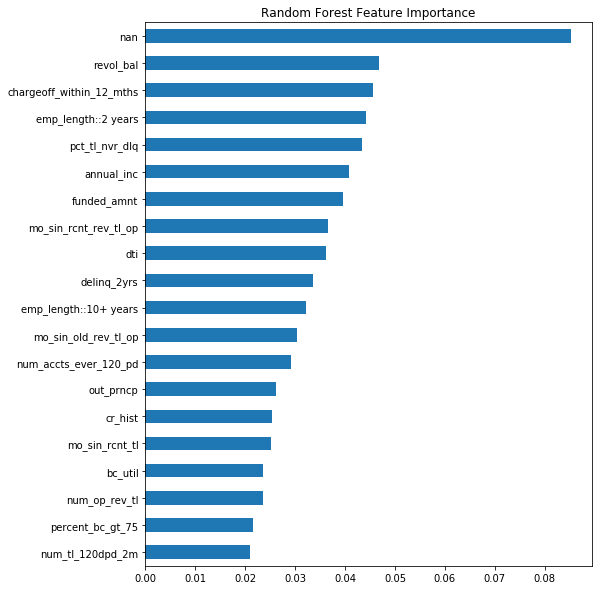

In [562]:
plt.figure(figsize = (8,10))
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-20:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
yticks = selected_features[top_idx]

p2 = bplot.plot(kind='barh',ylim=(0,0.2))
p2.set_yticklabels(yticks)
plt.title('Random Forest Feature Importance');

In [563]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = 41,
                        output_to_file = True):
    
    np.random.seed(random_state)
    
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_min', 'ret_reinv']
    
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:
        
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score

        if strategy == 'regr_classifier':

            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ((1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return)

            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            continue

        else:
            return 'Not a valid strategy'
        
    return out

  Model: Random forest
Fit time: 64.01 seconds
Optimal parameters:
{'min_samples_leaf': 10, 'n_estimators': 35}

Accuracy:  0.7312
             precision    recall  f1-score   support

 No default     0.8157    0.8452    0.8302     15550
    Default     0.3809    0.3328    0.3552      4450

avg / total     0.7190    0.7312    0.7245     20000



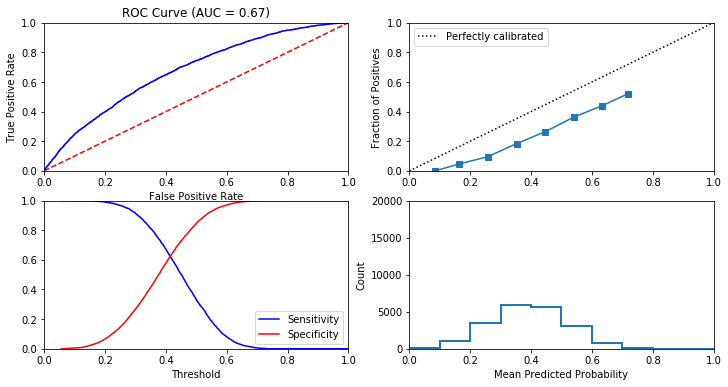

Random forest::roc_auc 0.6742668304490769


In [564]:
random_forest = RandomForestClassifier(class_weight='balanced')
cv_parameters = {'min_samples_leaf':[2,5,10], 'n_estimators': [15,35,75]}

random_forest = fit_classification(random_forest, data_dict,
                                   cv_parameters=cv_parameters, model_name="Random forest")

In [565]:
test_strategy = 'regr_classifier'

cv_parameters = {'min_samples_leaf':[25,50,100],
                 'n_estimators': [15,35,75]}

reg_rf_separate = fit_regression(RandomForestRegressor(), data_dict,
                       cv_parameters = cv_parameters, separate = True, model_name = "Random forest regressor")

print('Loan selection strategy:',test_strategy)
two_stage = test_investments(data_dict, classifier = random_forest, regressor = reg_rf_separate, 
                             strategy = test_strategy, num_loans = 1000)

col_list = ['ret_min', 'ret_reinv']

for ret_col in col_list:
    print(ret_col + ': ' + str(two_stage[ret_col]['average return']))

  Model: Random forest regressor  Return column: ret_min
Fit time: 284.76 seconds
Optimal parameters:
model_0: {'min_samples_leaf': 25, 'n_estimators': 75} model_1 {'min_samples_leaf': 25, 'n_estimators': 75}

Testing r2 scores:
model_0: 0.17000902223292613
model_1: 0.03995294112111292
  Model: Random forest regressor  Return column: ret_reinv
Fit time: 264.13 seconds
Optimal parameters:
model_0: {'min_samples_leaf': 25, 'n_estimators': 75} model_1 {'min_samples_leaf': 50, 'n_estimators': 75}

Testing r2 scores:
model_0: 0.22340378939886052
model_1: 0.035853117870023765
Loan selection strategy: regr_classifier
ret_min: 0.015136847990678461
ret_reinv: 0.05376948704711179


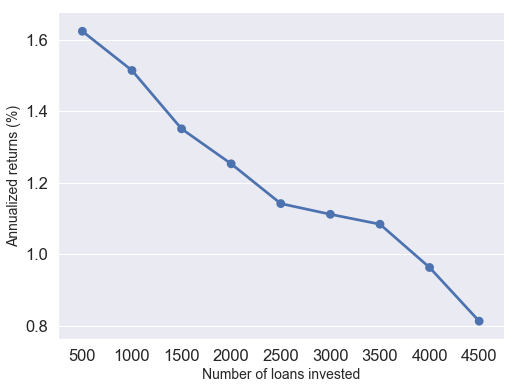

In [577]:
result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(500,5000,500)):

    reg_0 = test_investments(data_dict, regressor = reg_rf_separate, classifier = random_forest, 
                            strategy = 'regr_classifier', num_loans = num_loans)
    result_sensitivity.append(reg_0['ret_min']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
plt.figure(figsize = (8,6))
sns.pointplot(np.array(list(range(500,5000,500))),result_sensitivity)
sns.despine()
plt.ylabel('Annualized returns (%)',size = 14)
plt.xlabel('Number of loans invested',size = 14)
plt.show()

In [567]:
reg_0['ret_min']['average return']

0.008134309196733693

In [568]:
reg_0['ret_reinv']['average return']

0.04621945429236231

# End of notebook